In [2]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import re
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# 1. Load and select the first ICU admission record for each patient
chunksize = 50000
sample_fraction = 1
selected_columns = [
    'subject_id_x', 'age_years', 'admission_type', 'admission_location', 
    'discharge_location', 'insurance', 'marital_status', 'ethnicity', 'diagnosis', 
    'positiveculture', 'ab_name', 'antibioticresistance', 
    'gcs', 'gcseyes', 'gcsmotor', 'gcsverbal', 'endotrachflag', 'neutrophil', 
    'creactiveprotein', 'whitebloodcell', 'partialpressureo2', 'bicarbonate', 
    'lactate', 'troponin', 'bloodureanitrogen', 'creatinine', 'alaninetransaminase', 
    'aspartatetransaminase', 'hemoglobin', 'intnormalisedratio', 'platelets', 
    'albumin', 'chloride', 'glucose', 'sodium', 'bilirubin', 'hematocrit', 
    'first_careunit', 'last_careunit', 'los_x', 'intime_x', 'outtime_x', 
    'expire_flag'
]

# Load and filter the first ICU admission record for each patient
filtered_chunks = []
for chunk in pd.read_csv('/root/DATA/filtered_merged_data.csv', usecols=selected_columns, chunksize=chunksize, low_memory=False):
    chunk_sample = chunk.sample(frac=sample_fraction, random_state=42)
    chunk_sorted = chunk_sample.sort_values('intime_x').drop_duplicates(subset='subject_id_x', keep='first')
    filtered_chunks.append(chunk_sorted)

filtered_data = pd.concat(filtered_chunks, ignore_index=True)

# Add a new column for is_weekend_admission based on intime_x
filtered_data['intime_x'] = pd.to_datetime(filtered_data['intime_x'], errors='coerce')
filtered_data['is_weekend_admission'] = filtered_data['intime_x'].dt.weekday >= 5  # 周六和周日为 True

# Remove datetime columns before scaling
filtered_data = filtered_data.drop(columns=['intime_x', 'outtime_x'])

# 2. Separate features and target (using long-term mortality with 'expire_flag')
X = filtered_data.drop(columns=['expire_flag', 'subject_id_x'], errors='ignore')
y = filtered_data['expire_flag']

# 3. Fill missing values
for col in X.columns:
    if X[col].dtype == 'float64':
        X[col] = X[col].fillna(X[col].median())
    elif X[col].dtype == 'object':
        X[col] = X[col].fillna('Unknown')

# 4. Encode categorical variables and standardize
X_encoded = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# 5. Use Lasso for feature selection
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y)

# 6. Filter Lasso-selected important features
pattern = re.compile(r'(_\d{4}-\d{2}-\d{2})|(_[A-Z]{2,}\d*)')
lasso_selected_features = [feat for feat in X_encoded.columns[(lasso.coef_ != 0)] if not pattern.search(feat)]
print("Filtered Lasso-selected important features:", lasso_selected_features)

# Manually ensure these important features are included, including dummy variables
mandatory_features = [
    'age_years', 'gcsverbal', 'gcsmotor', 'bloodureanitrogen',
    'admission_location_EMERGENCY ROOM ADMIT', 'admission_location_PHYS REFERRAL/NORMAL DELI',
    'admission_location_CLINIC REFERRAL/PREMATURE', 'admission_location_TRANSFER FROM HOSP/EXTRAM',
    'admission_type_URGENT', 'is_weekend_admission'
]

# Add each mandatory feature if it’s missing
for feature in mandatory_features:
    if feature not in lasso_selected_features:
        lasso_selected_features.append(feature)

print("Final feature list after manually adding mandatory features:", lasso_selected_features)

# 7. Generate the final encoded dataset with selected features, ensuring column consistency
final_data_encoded = pd.get_dummies(filtered_data, drop_first=True)
for col in lasso_selected_features:
    if col not in final_data_encoded.columns:
        final_data_encoded[col] = 0  # Add missing columns and fill with 0

# Include 'expire_flag' as the target variable in the final dataset
final_data_selected = final_data_encoded[lasso_selected_features + ['expire_flag']]

# 8. Fill NaN values for specific columns
for col in ['bloodureanitrogen', 'intnormalisedratio', 'chloride', 'hematocrit']:
    if col in final_data_selected.columns:
        final_data_selected[col].fillna(final_data_selected[col].median(), inplace=True)

# 9. Check for NaN values
nan_summary = final_data_selected.isna().sum()
print("NaN Value Statistics After Filling:")
print(nan_summary[nan_summary > 0])

# Check the final shape of the data
print("Final dataset shape:", final_data_selected.shape)

# Save the final data
output_path = '/root/DATA/cleaned_cox_dataset.csv'
final_data_selected.to_csv(output_path, index=False)
print(f"The cleaned data with long-term mortality flag as 'expire_flag' has been exported to {output_path}")


Filtered Lasso-selected important features: ['los_x', 'positiveculture', 'gcs', 'gcsmotor', 'lactate', 'bloodureanitrogen', 'hemoglobin', 'intnormalisedratio', 'albumin', 'chloride', 'hematocrit', 'age_years', 'insurance_Medicare']
Final feature list after manually adding mandatory features: ['los_x', 'positiveculture', 'gcs', 'gcsmotor', 'lactate', 'bloodureanitrogen', 'hemoglobin', 'intnormalisedratio', 'albumin', 'chloride', 'hematocrit', 'age_years', 'insurance_Medicare', 'gcsverbal', 'admission_location_EMERGENCY ROOM ADMIT', 'admission_location_PHYS REFERRAL/NORMAL DELI', 'admission_location_CLINIC REFERRAL/PREMATURE', 'admission_location_TRANSFER FROM HOSP/EXTRAM', 'admission_type_URGENT', 'is_weekend_admission']
NaN Value Statistics After Filling:
gcsmotor         75
lactate       15812
hemoglobin     9493
albumin       18060
gcsverbal        67
dtype: int64
Final dataset shape: (20101, 21)
The cleaned data with long-term mortality flag as 'expire_flag' has been exported to /ro

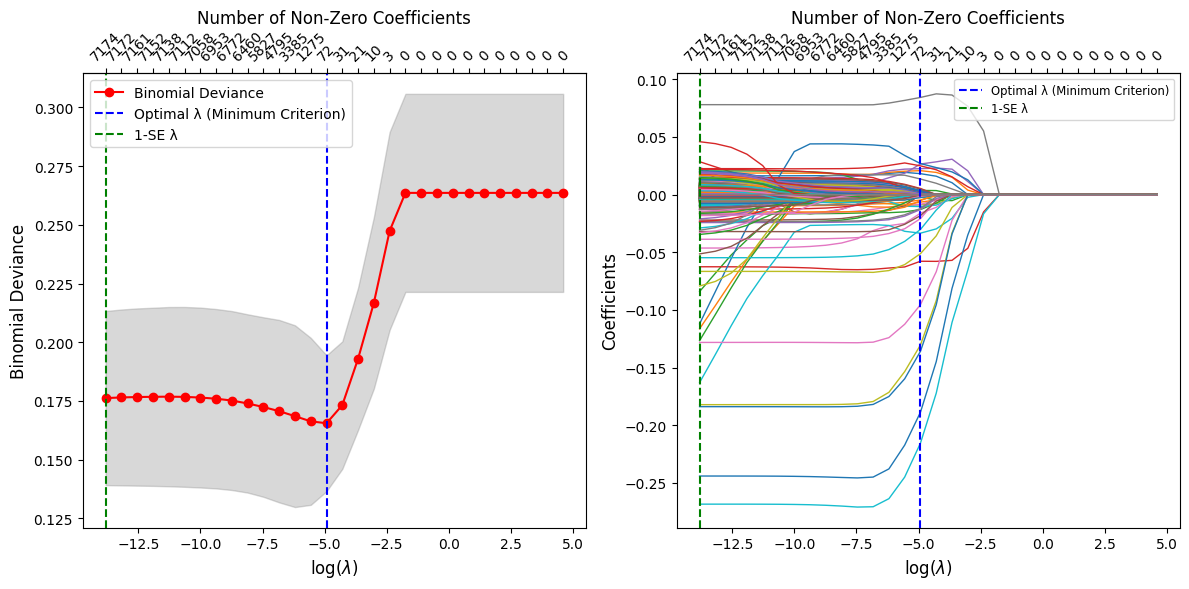

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, lasso_path

# Perform LassoCV with reduced alphas and parallel processing
lasso_cv = LassoCV(alphas=np.logspace(-6, 2, 30), cv=5, random_state=42, n_jobs=-1)
lasso_cv.fit(X_scaled, y)

# Start figure
plt.figure(figsize=(12, 6))

# Panel A: Binomial Deviance Curve
plt.subplot(1, 2, 1)

# Calculate mean and standard deviation of cross-validation errors
mean_cv_errors = np.mean(lasso_cv.mse_path_, axis=1)
std_cv_errors = np.std(lasso_cv.mse_path_, axis=1)
min_error = np.min(mean_cv_errors)  # Minimum error
min_error_index = np.argmin(mean_cv_errors)  # Index of minimum error
se_threshold = min_error + std_cv_errors[min_error_index]  # 1-SE threshold
one_se_index = np.where(mean_cv_errors <= se_threshold)[0][-1]  # Index of 1-SE lambda
one_se_lambda = lasso_cv.alphas_[one_se_index]  # Lambda at 1-SE

# Convert to log(lambda) for bottom axis
log_lambdas = np.log(lasso_cv.alphas_)

# Compute coefficients path using lasso_path
alphas, coefs, _ = lasso_path(X_scaled, y, alphas=lasso_cv.alphas_)

# Compute non-zero coefficients for each lambda
non_zero_counts = np.sum(np.abs(coefs) > 1e-5, axis=0)  # Number of non-zero coefficients

# Plot Mean Squared Error (MSE)
plt.plot(log_lambdas, mean_cv_errors, 'r-o', label="Binomial Deviance")
plt.fill_between(
    log_lambdas,
    mean_cv_errors - std_cv_errors,
    mean_cv_errors + std_cv_errors,
    color='gray', alpha=0.3
)
# Mark optimal lambda (Minimum Criterion)
plt.axvline(np.log(lasso_cv.alpha_), color='b', linestyle='--', label="Optimal λ (Minimum Criterion)")
# Mark 1-SE lambda
plt.axvline(np.log(one_se_lambda), color='g', linestyle='--', label="1-SE λ")

# Add bottom axis labels
plt.xlabel(r"$\log(\lambda)$", fontsize=12)
plt.ylabel("Binomial Deviance", fontsize=12)

# Add top axis for non-zero coefficients
ax1 = plt.gca()
secax1 = ax1.secondary_xaxis('top')  # Add secondary axis at the top
secax1.set_xlabel("Number of Non-Zero Coefficients", fontsize=12)
secax1.set_xticks(log_lambdas)  # Align ticks with log(lambda)
secax1.set_xticklabels(non_zero_counts, rotation=45, fontsize=10)  # Display non-zero coefficients as labels
plt.legend()

# Panel B: Coefficient Profiles
plt.subplot(1, 2, 2)

# Plot coefficient paths for all features
log_lambdas_path = np.log(alphas)
for coef_path in coefs:
    plt.plot(log_lambdas_path, coef_path, lw=1)

# Mark optimal lambda (Minimum Criterion)
plt.axvline(np.log(lasso_cv.alpha_), color='b', linestyle='--', label="Optimal λ (Minimum Criterion)")
# Mark 1-SE lambda
plt.axvline(np.log(one_se_lambda), color='g', linestyle='--', label="1-SE λ")

# Add bottom axis labels
plt.xlabel(r"$\log(\lambda)$", fontsize=12)
plt.ylabel("Coefficients", fontsize=12)

# Add top axis for non-zero coefficients
ax2 = plt.gca()
secax2 = ax2.secondary_xaxis('top')  # Add secondary axis at the top
secax2.set_xlabel("Number of Non-Zero Coefficients", fontsize=12)
secax2.set_xticks(log_lambdas_path)  # Align ticks with log(lambda)
secax2.set_xticklabels(non_zero_counts, rotation=45, fontsize=10)  # Display non-zero coefficients as labels
plt.legend(loc="upper right", fontsize='small')

# Finalize layout
plt.tight_layout()
plt.show()
